<a href="https://colab.research.google.com/github/tngjody/bt4221-airfare-booking/blob/main/BT4221_Group_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H




# Data Loading & Exploration

In [1]:
from pyspark.sql import SparkSession

# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
flight_df.show(5, truncate=False)

# Display schema
flight_df.printSchema()

# Total Count
flight_df.count()

+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------------------------------------------+-------------------------------+------------------------------------------------------------+--------------------------+----------------------------+-------------------+-------------------+------------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw                                    |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw                          

2000000

# Data Cleaning & Pre-processing

In [2]:
# Remove rows with null values

# Drop duplicates
flight_df = flight_df.dropDuplicates()

# Final Count
flight_df.count()

print(f"Number of rows after dropping duplicates: {flight_df.count()}")
print(f"Number of columns: {len(flight_df.columns)}")

Number of rows after dropping duplicates: 2000000
Number of columns: 27


In [3]:
from pyspark.sql.functions import col, sum, isnan
from pyspark.sql.types import NumericType

# Build expressions to count missing values (null and NaN for numeric columns; null only otherwise)
missing_exprs = []
for field in flight_df.schema.fields:
    if isinstance(field.dataType, NumericType):
        # For numeric columns, count both nulls and NaNs
        expr = sum((col(field.name).isNull() | isnan(col(field.name))).cast("int")).alias(field.name)
    else:
        # For non-numeric columns, count only nulls
        expr = sum(col(field.name).isNull().cast("int")).alias(field.name)
    missing_exprs.append(expr)

# Compute missing values count per column
missing_counts = flight_df.select(*missing_exprs)
missing_counts.show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

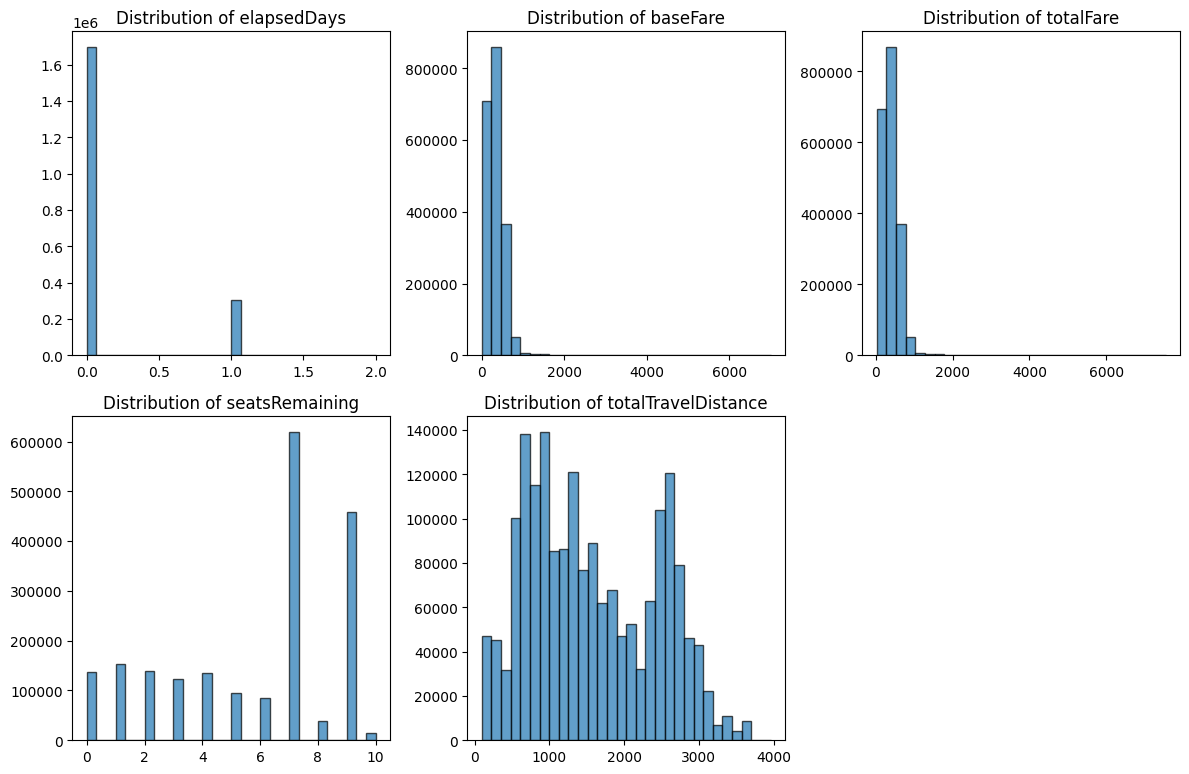

In [4]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Plot histograms directly from PySpark DataFrame
plt.figure(figsize=(12, 8))

for i, col_name in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)  # Creates a grid of subplots

    # Collect data from PySpark DataFrame
    data = flight_df.select(col_name).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

    # Plot histogram
    plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()